In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Models import GaussianPulse as G
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import argrelextrema

In [3]:
omp = 1
mpi = 4

In [4]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt')
#code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',scheduler='slurm',sbatch_options=['--partition=all12h'])

Initialize a Yambo calculator with scheduler direct


In [5]:
# Common parameters (eventually overwritten by the dictionary values)
fwhm = 100 #fs
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

# RT analysis of GaAs

This notebook contains the RT analysis of the photon echo mechanism for GaAs performed with Yambo.

## Analysis of a single transition with a single pulse in various cases

We study the behavior of a simulation in which there is a single $k$ point (using the nosym option).

We select a $k$-point with valence conduction gap of 1.5 eV, for this point the three conduction bands
are not degenerate and thus we can isolate the 4,5 transition. This situation should be described by
the physics of a standard TLS (with the only difference provided by the spin degeneration that brings
a factor 2 in the number of carriers)

First we compute the dipoles, that are needed to determine the intensity of the field.
To use the dipoles in a consistent way with the real-time analysis we use the ndb.dipoles produced by 
a rt calculation performed starting from the same SAVE folder. We cannot perform a separate yambo -dipoles 
because in the rt analysis we are removing the contribution os the pseudo to the commutator
of the hamiltonian.

In [6]:
dipoles = P.YamboDipolesParser('RT_singlek1.5_nosym/pi2/ndb.dipoles')
dipoles.get_info()

Parse file : RT_singlek1.5_nosym/pi2/ndb.dipoles
Spin dipoles not found in the ndb.dipoles
YamboDipolesParser variables structure
dip_ir shape (1, 2, 2, 3, 2)
dip_p shape (1, 2, 2, 3, 2)
dip_v shape (1, 2, 2, 3, 2)
dip_spin shape (1,)


In [7]:
x_dip = dipoles.get_r_dipole(0,1,0,0) # x_dip = x_{10} 
x_dip

(6.160434618186675-18.397226229218063j)

In [8]:
theta = 0.5*np.pi
pars_pi2 = G.pulseParametersFromTheta(x_dip,theta,fwhm=fwhm)
theta = np.pi
pars_pi = G.pulseParametersFromTheta(x_dip,theta,fwhm=fwhm)

time unit: fs
set width to 42.466090014400955 fs
Rabi coupling (fs^-1): (0.004685641795734993-0.013992975737577105j)
Rabi coupling (module) (fs^-1): 0.014756646266356057
field amplitude (V/m): 9460680.490869798
field intensity (kW/cm^2) : 23758.235602964178
time unit: fs
set width to 42.466090014400955 fs
Rabi coupling (fs^-1): (0.009371283591469985-0.02798595147515421j)
Rabi coupling (module) (fs^-1): 0.029513292532712114
field amplitude (V/m): 18921360.981739596
field intensity (kW/cm^2) : 95032.94241185671


We define the dictionary with the simulations parameters

In [18]:
simulations = {
    'pi2': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 23758, 
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'skip'      : True,
        'bands'     : [4,5]
    },
    'pi': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 95032, 
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'skip'      : True,
        'bands'     : [4,5]
    },
    'pi2_detune': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 23758, 
        'field_eng' : 1.52,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'skip'      : True,
        'bands'     : [4,5]
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [19]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=polarization,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE for pi2 sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for pi sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for pi2_detune sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [20]:
io_time = [1.0,0.1,0.1] # I/O (CARRIERs - GF - OUTPUT) in fs

In [21]:
for pars in simulations.values():
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],fwhm=fwhm,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=pars['bands'],scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],io_time=io_time,time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['arguments'].append('SaveGhistory')
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

In [22]:
#simulations['pi2']

In [23]:
study = D.Dataset(num_tasks=1)
study.set_postprocessing_function(D.PostProcessing.yambo_parse_data)

Initialize a Dataset with 1 parallel tasks


In [24]:
for id,sim in simulations.items():
    study.append_run(id=id,input=sim['input'],run_dir=sim['rt_run_dir'],runner=code,skip=sim['skip'])

In [25]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of pi2
Task [0] ended 

Run the task [1] 
Skip the run of pi
Task [1] ended 

Run the task [2] 
Skip the run of pi2_detune
Task [2] ended 



0.996676505
1.99804807
0.186200306


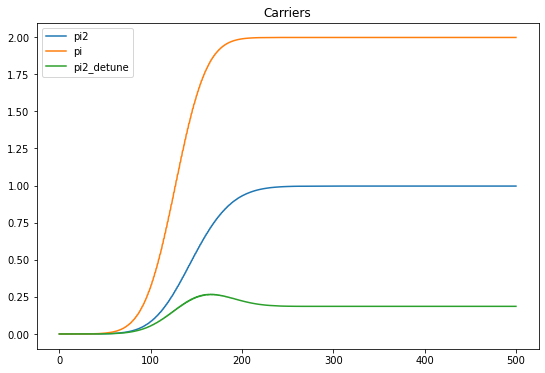

In [26]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['carriers']['time']
    dne = r.data['carriers']['dne']
    print(dne[-1])
    plt.plot(t,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Carriers')
    plt.legend()
    #plt.show()

In [192]:
#results[0].get_info()

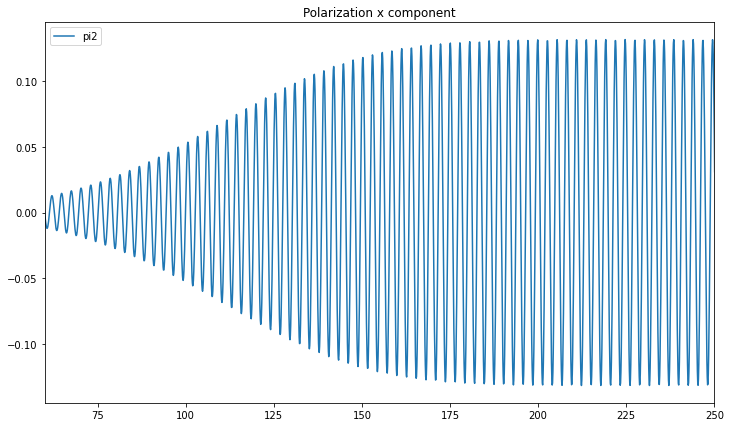

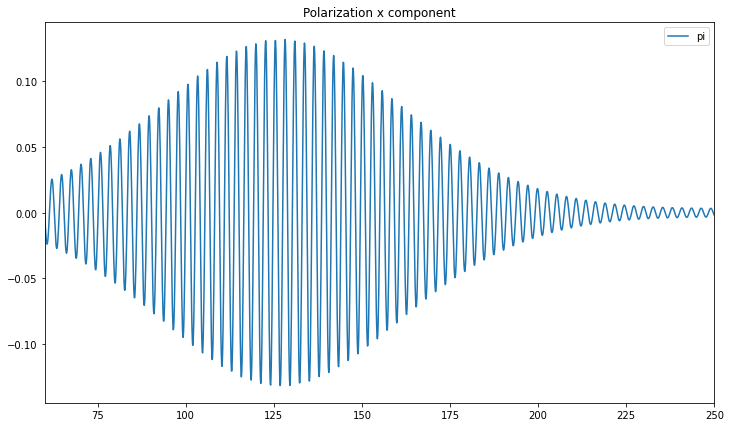

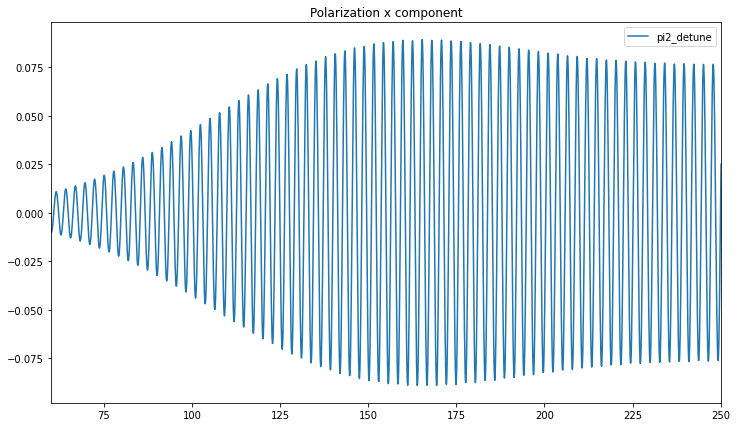

In [194]:
for ind,r in results.items():
    plt.figure(figsize=(12,7))
    t = r.data['polarization']['time']
    dne = r.data['polarization']['Pol_x']
    plt.plot(t,dne,label=D.name_from_id(study.ids[ind]))
    #plt.scatter(t,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Polarization x component')
    plt.legend()
    plt.xlim(60,250)
    plt.show()

### Density matrix and Bloch vector

In [208]:
sim = 2

We build the time dependent density matrix 

In [209]:
green = results[sim].RTGreen
dm0 = green.buildEqDensityMatrix()
dm = green.buildDensityMatrix(equilibrium_dm=dm0)
ntimes = len(dm) # dimension of the time index
nk = len(dm[0]) # dimension of the index
dm.shape

(10001, 1, 2, 2)

In [210]:
dm[1000,0]

array([[ 1.99886241e+00+0.j        , -4.76723889e-02+0.00069934j],
       [-4.76723889e-02-0.00069934j,  1.13758573e-03+0.j        ]])

We define a time variable that convert the time index of the density matrix in
the effective simulation time

In [211]:
NETime = 500
green_time = np.linspace(0,NETime,ntimes)
green_time.shape

(10001,)

From the dm we can compute the number of carriers in function of time

In [212]:
trace_cc = np.trace(dm[:,:,1:,1:],axis1=2,axis2=3) #trace in the conduction sector
carriers = np.mean(trace_cc,axis=1) # average over k

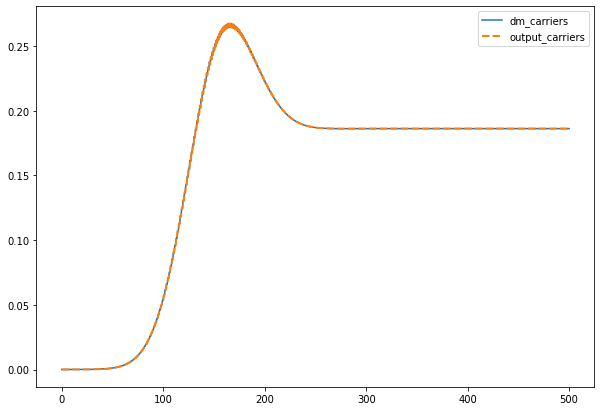

In [213]:
plt.figure(figsize=(10,7))
plt.plot(green_time,carriers.real,label='dm_carriers')
results_time = results[sim].data['carriers']['time']
dne = results[sim].data['carriers']['dne']
plt.plot(results_time,dne,label='output_carriers',linestyle='--',linewidth=2)
plt.legend()

We can compute also the expectation value of the polarization and compare with the one
provided in the output files (it has to be rescaled with the lattice volume)

In [214]:
dft = results[sim].dft
lat_vol = dft.eval_lattice_volume()

Since x_dip is $x_{10}$ it couples with $\rho_{01}$

In [215]:
Px = (dm[:,0,0,1]*x_dip + dm[:,0,1,0]*x_dip.conjugate()).real
Px /= lat_vol

(60.0, 200.0)

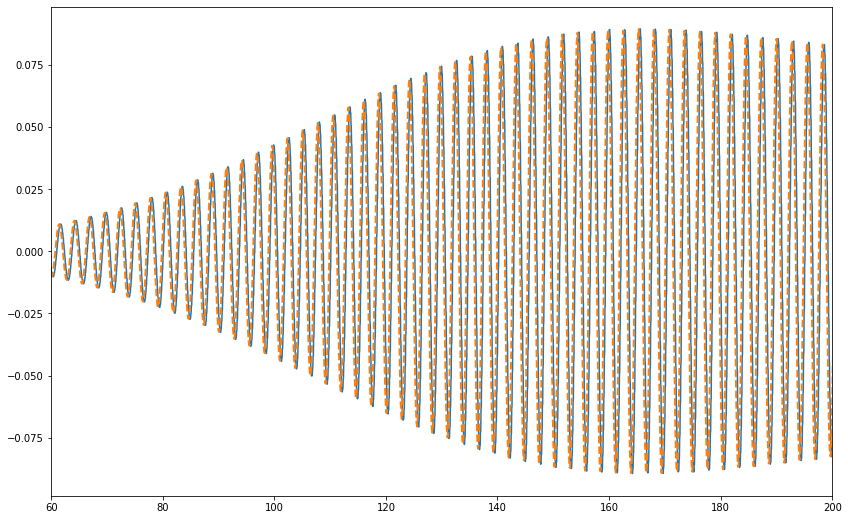

In [218]:
plt.figure(figsize=(14,9))
plt.plot(green_time,Px.real)
results_time = results[sim].data['polarization']['time']
pol_x = results[sim].data['polarization']['Pol_x']
plt.plot(results_time,pol_x,label='output_pol',linestyle='--',linewidth=2)
plt.xlim(60,200)

There is a very small time shift of about 0.25 fs...to be investigated.

We build the Bloch vector from the density matrix

In [219]:
Bloch = P.buildBlochVectors(dm)
Bloch.shape

(3, 10001, 1)

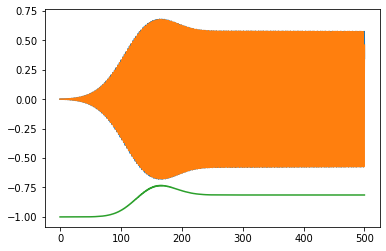

In [220]:
plt.plot(green_time,Bloch[0,:,0])
plt.plot(green_time,Bloch[1,:,0])
plt.plot(green_time,Bloch[2,:,0])

We can compute the polarization using the Bloch vector

In [221]:
Px_Bloch = 2*(Bloch[0,:,0]*x_dip.real + Bloch[1,:,0]*x_dip.imag) # factor 2 for the spin degeneration
Px_Bloch /= lat_vol

(60.0, 200.0)

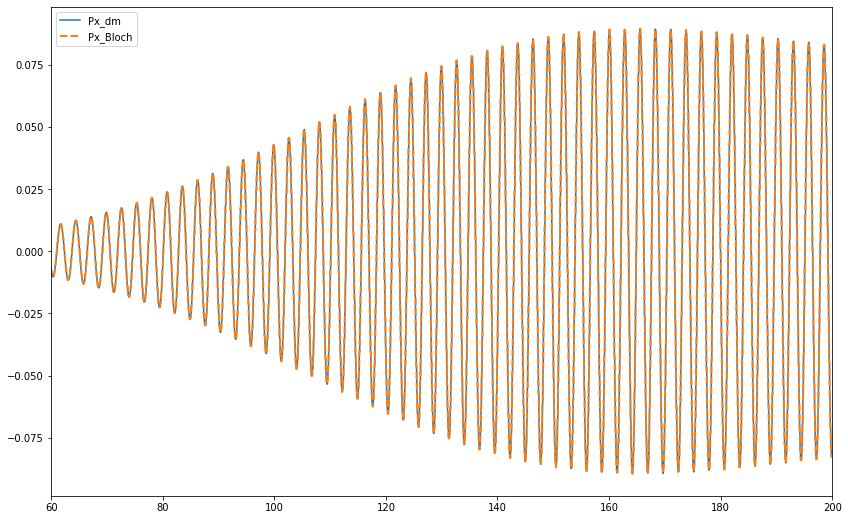

In [223]:
plt.figure(figsize=(14,9))
plt.plot(green_time,Px,label='Px_dm')
plt.plot(green_time,Px_Bloch,label='Px_Bloch',linestyle='--',linewidth=2)
plt.legend()
plt.xlim(60,200)

## Analysis of a single transition with a double pulse in various cases

We apply a double pulse in the $\pi/2-\pi$ configuration. We consider both the cases in which the
energy of the pulse is resonant with the gap and the one in which there a finite detuning. 

We consider the same $k$ point with cv gap of 1.5 eV used for the single pulse cases.

In [23]:
dipoles = P.YamboDipolesParser('RT_singlek1.5_nosym/pi2/ndb.dipoles')
dipoles.get_info()

Parse file : RT_singlek1.5_nosym/pi2/ndb.dipoles
Spin dipoles not found in the ndb.dipoles
YamboDipolesParser variables structure
dip_ir shape (1, 2, 2, 3, 2)
dip_p shape (1, 2, 2, 3, 2)
dip_v shape (1, 2, 2, 3, 2)
dip_spin shape (1,)


In [24]:
x_dip = dipoles.get_r_dipole(0,1,0,0) # x_dip = x_{10} 
x_dip

(6.160434618186675-18.397226229218063j)

In [25]:
theta = 0.5*np.pi
pars_pi2 = G.pulseParametersFromTheta(x_dip,theta,fwhm=fwhm)
theta = np.pi
pars_pi = G.pulseParametersFromTheta(x_dip,theta,fwhm=fwhm)

time unit: fs
set width to 42.466090014400955 fs
Rabi coupling (fs^-1): (0.004685641795734993-0.013992975737577105j)
Rabi coupling (module) (fs^-1): 0.014756646266356057
field amplitude (V/m): 9460680.490869798
field intensity (kW/cm^2) : 23758.235602964178
time unit: fs
set width to 42.466090014400955 fs
Rabi coupling (fs^-1): (0.009371283591469985-0.02798595147515421j)
Rabi coupling (module) (fs^-1): 0.029513292532712114
field amplitude (V/m): 18921360.981739596
field intensity (kW/cm^2) : 95032.94241185671


We define the dictionary with the simulations parameters

The second pulse start after an integer number of periods of the first one. In this way
the fast sinusoidal oscillations of the two pulses match. This is useful if we want to describe
the dynamics using the TLS where there is a single fast oscillations with a double gaussian
envelope.

In [82]:
energy = 1.5 # eV
h = U.Constants.Planck_ev_ps*1e3
period = h/energy # in fs
print(period)
tstart = period*218 #363
tstart

2.7571117973333332


601.0503718186667

In [84]:
simulations = {
    'pi2-pi2': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'fields'  : [dict(index=1,int=23758,freq=energy,fwhm=fwhm,polarization='linear'),
                     dict(index=2,int=23758,freq=energy,fwhm=fwhm,polarization='linear',tstart=tstart,tstart_units='fs')],
        'sim_time'  : 2000,
        'eta'       : 1e-5,
        'no_sym'    : True,
        'skip'      : True,
        'bands'     : [4,5]
    },
    'pi2-pi': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'fields'  : [dict(index=1,int=23758,freq=energy,fwhm=fwhm,polarization='linear'),
                     dict(index=2,int=95032,freq=energy,fwhm=fwhm,polarization='linear',tstart=tstart,tstart_units='fs')],
        'sim_time'  : 2000,
        'eta'       : 1e-5,
        'no_sym'    : True,
        'skip'      : True,
        'bands'     : [4,5]
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [85]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=polarization,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE for pi2-pi2 sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for pi2-pi sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [86]:
io_time = [1.0,0.1,0.1] # I/O (CARRIERs - GF - OUTPUT) in fs

In [87]:
for pars in simulations.values():
    rt_input = I.YamboInput('yambo_rt -n p2 -v ip -V rt',folder=pars['rt_run_dir'])
    for f in pars['fields']:
        rt_input.set_rt_field(**f)
    rt_input.set_rt_bands(bands=pars['bands'],scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],io_time=io_time,time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['arguments'].append('SaveGhistory')
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

In [88]:
#simulations['pi2-pi']

In [89]:
study = D.Dataset(num_tasks=1)
study.set_postprocessing_function(D.PostProcessing.yambo_parse_data)

Initialize a Dataset with 1 parallel tasks


In [90]:
for id,sim in simulations.items():
    study.append_run(id=id,input=sim['input'],run_dir=sim['rt_run_dir'],runner=code,skip=sim['skip'])

In [91]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0], [1]] 

Run the task [0] 
run command: cd RT_singlek1.5_nosym; mpirun -np 4 yambo_rt -F pi2-pi2.in -J pi2-pi2 -C pi2-pi2
computation pi2-pi2 is running...
computation pi2-pi2 ended
Task [0] ended 

Run the task [1] 
Skip the run of pi2-pi
Task [1] ended 



1.97827446
1.00515378


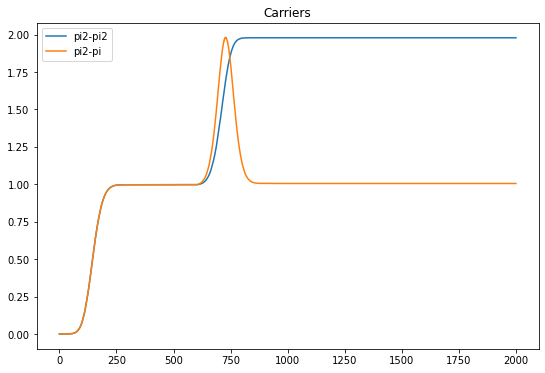

In [92]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['carriers']['time']
    dne = r.data['carriers']['dne']
    print(dne[-1])
    plt.plot(t,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Carriers')
    plt.legend()
    #plt.show()

In [93]:
#results[0].get_info()

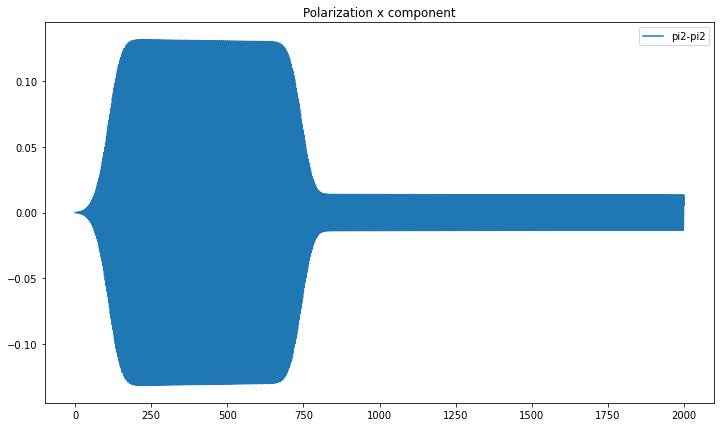

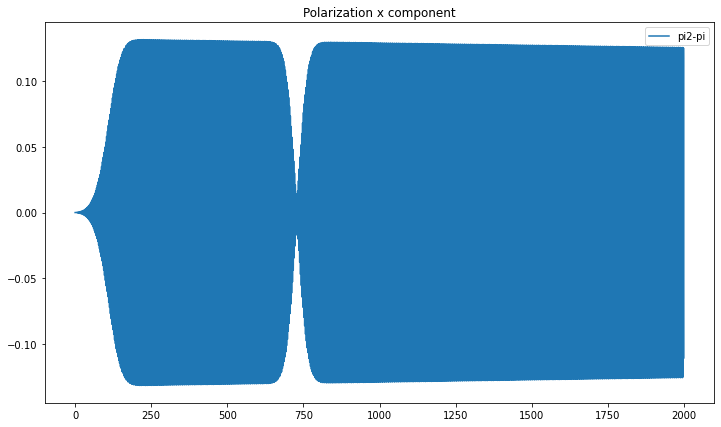

In [95]:
for ind,r in results.items():
    plt.figure(figsize=(12,7))
    t = r.data['polarization']['time']
    dne = r.data['polarization']['Pol_x']
    plt.plot(t,dne,label=D.name_from_id(study.ids[ind]))
    #plt.scatter(t,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Polarization x component')
    plt.legend()
    plt.show()

### Density matrix and Bloch vector

In [96]:
study.ids

['pi2-pi2', 'pi2-pi']

In [112]:
sim = 1

We build the time dependent density matrix 

In [113]:
green = results[sim].RTGreen
dm0 = green.buildEqDensityMatrix()
dm = green.buildDensityMatrix(equilibrium_dm=dm0)
ntimes = len(dm) # dimension of the time index
nk = len(dm[0]) # dimension of the index
dm.shape

(40001, 1, 2, 2)

In [114]:
dm[1000,0]

array([[ 1.99862532e+00+0.j        , -2.54293801e-02-0.04582491j],
       [-2.54293801e-02+0.04582491j,  1.37468090e-03+0.j        ]])

We define a time variable that convert the time index of the density matrix in
the effective simulation time

In [115]:
NETime = 2000
green_time = np.linspace(0,NETime,ntimes)
green_time.shape

(40001,)

From the dm we can compute the number of carriers in function of time

In [116]:
trace_cc = np.trace(dm[:,:,1:,1:],axis1=2,axis2=3) #trace in the conduction sector
carriers = np.mean(trace_cc,axis=1) # average over k

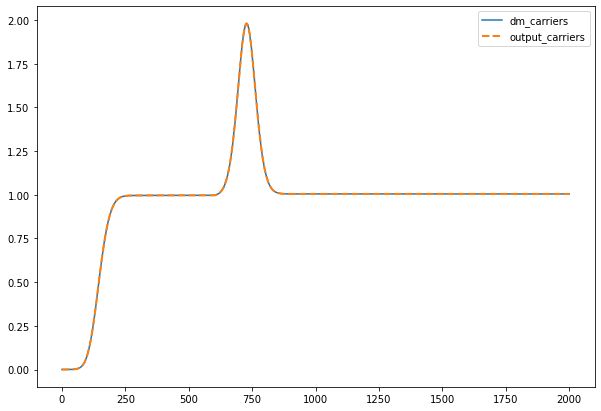

In [117]:
plt.figure(figsize=(10,7))
plt.plot(green_time,carriers.real,label='dm_carriers')
results_time = results[sim].data['carriers']['time']
dne = results[sim].data['carriers']['dne']
plt.plot(results_time,dne,label='output_carriers',linestyle='--',linewidth=2)
plt.legend()

We can compute also the expectation value of the polarization and compare with the one
provided in the output files (it has to be rescaled with the lattice volume)

In [118]:
dft = results[sim].dft
lat_vol = dft.eval_lattice_volume()

Since x_dip is $x_{10}$ it couples with $\rho_{01}$

In [119]:
Px = (dm[:,0,0,1]*x_dip + dm[:,0,1,0]*x_dip.conjugate()).real
Px /= lat_vol

(600.0, 900.0)

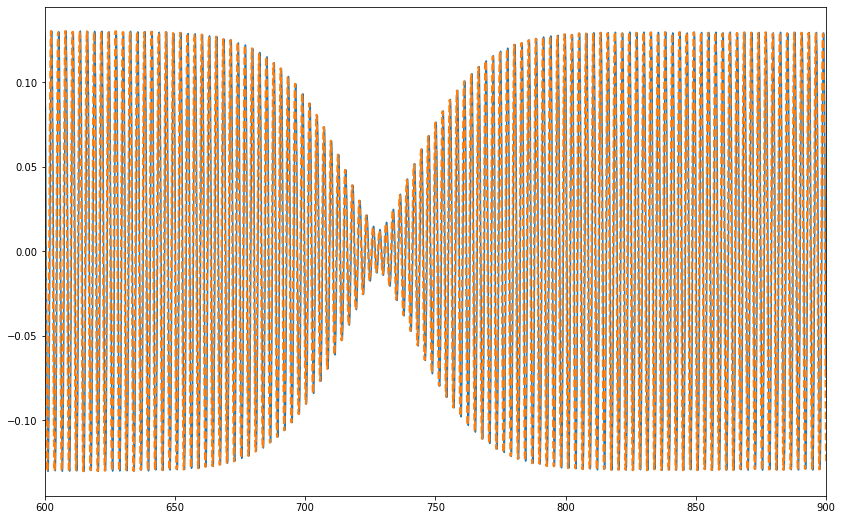

In [120]:
plt.figure(figsize=(14,9))
plt.plot(green_time,Px.real)
results_time = results[sim].data['polarization']['time']
pol_x = results[sim].data['polarization']['Pol_x']
plt.plot(results_time,pol_x,label='output_pol',linestyle='--',linewidth=2)
plt.xlim(600,900)

We build the Bloch vector from the density matrix

In [121]:
Bloch = P.buildBlochVectors(dm)
Bloch.shape

(3, 40001, 1)

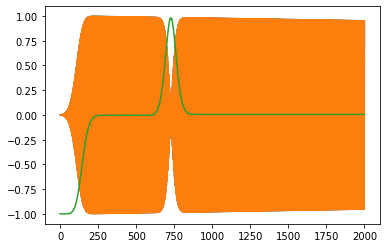

In [122]:
plt.plot(green_time,Bloch[0,:,0])
plt.plot(green_time,Bloch[1,:,0])
plt.plot(green_time,Bloch[2,:,0])

We can compute the polarization using the Bloch vector

In [123]:
Px_Bloch = 2*(Bloch[0,:,0]*x_dip.real + Bloch[1,:,0]*x_dip.imag) # factor 2 for the spin degeneration
Px_Bloch /= lat_vol

(600.0, 900.0)

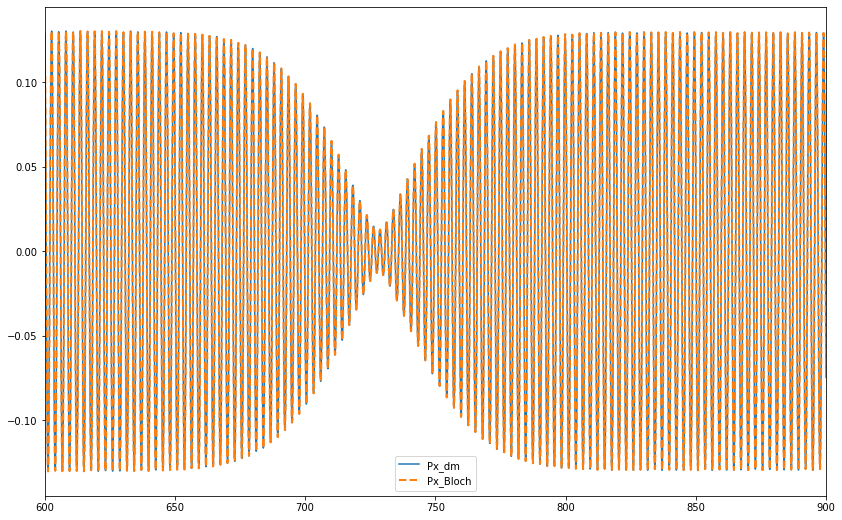

In [124]:
plt.figure(figsize=(14,9))
plt.plot(green_time,Px,label='Px_dm')
plt.plot(green_time,Px_Bloch,label='Px_Bloch',linestyle='--',linewidth=2)
plt.legend()
plt.xlim(600,900)

In [ ]:
################################################################################################à

## Multi $k$ analysis - Single gaussian pulse. Analysis of FID

In [32]:
simulations = {
    'pi2': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04', 
        'field_int' : 23758,
        'field_eng' : 1.5,
        'sim_time'  : 1000,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'pi2_single-trans': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04', 
        'field_int' : 23758,
        'field_eng' : 1.5,
        'sim_time'  : 1000,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01,
        'bands'     : [4,5],
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [33]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for pi2
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for pi2_single-trans
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [35]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [36]:
sel_sim = simulations
#sel_sim = dict((k,simulations[k]) for k in ['low_pulse','pi2'])

In [37]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)

for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    if pars.get('Gauge') is not None:
        idd['gauge'] = pars['Gauge']
    if pars.get('bands') is not None:
        idd['bands'] = 'single-trans'
    name = D.name_from_id(idd)
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

Initialize a parallel Yambo calculator with scheduler direct
run the computation for pi2
Skip the run of eta_1e-05-field_eng_1.5-field_int_23758-sim_time_1000
Job completed

run the computation for pi2_single-trans
Skip the run of bands_single-trans-eta_1e-05-field_eng_1.5-field_int_23758-sim_time_1000
Job completed



In [38]:
#sel_sim = dict((k,simulations[k]) for k in ['k1_st_pi_nosym','k1_st_pi2_nosym','k1_st_hi_nosym'])

0.488259557
0.233527889


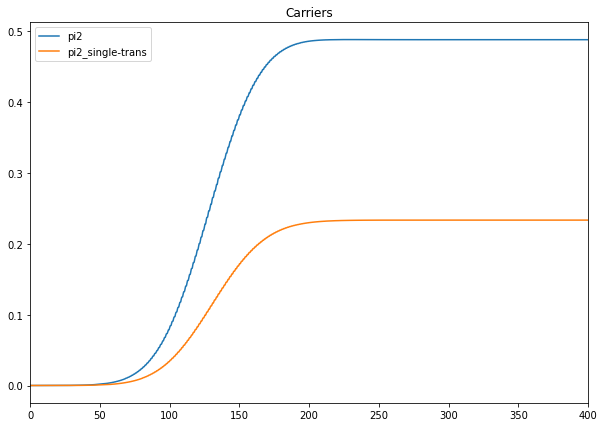

In [40]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    print(dne[-1])
    #plt.hlines(1.,0,400,linestyles='--')
    #plt.hlines(2,0,400,linestyles='--')
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

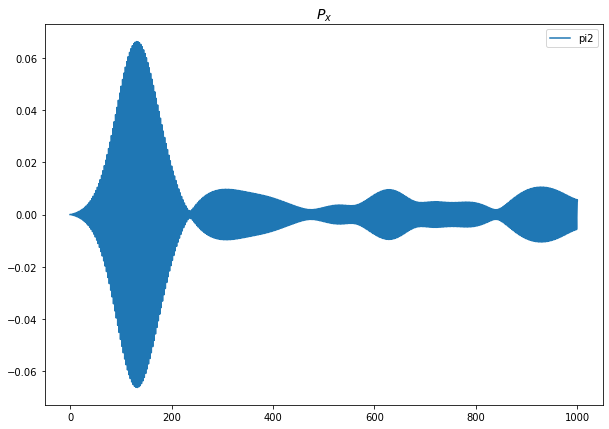

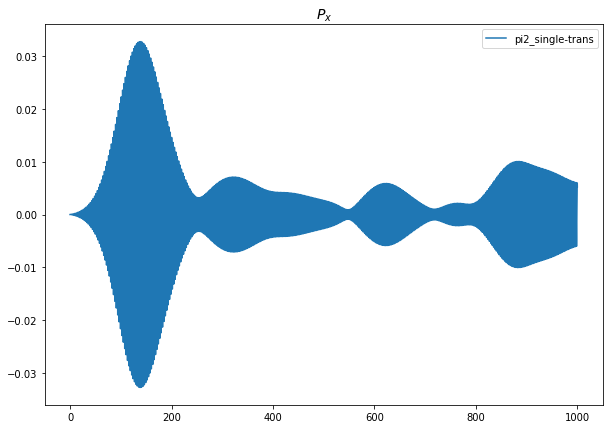

In [85]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

## Multi $k$ analysis - Double gaussian pulse for echo mechanism

We build of the dictionary with the parameters of the various simulations.

In [67]:
pulse_energy = 1.5 # eV
T_pulse = U.Planck_ev_ps*1e3/pulse_energy # in fs
T_pulse
T_delay = T_pulse* 363
T_delay

1000.831582432

In [68]:
simulations = {
    'echo_pi2-pi': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04',
        'field_pol' : 'linear', # a common value since is used for the fixsymm
        'fields'  : {1 : {'int' : 23758, 'eng' : 1.5, 'width' : 100,'tstart' : 0},
                     2 : {'int' : 95033, 'eng' : 1.5, 'width' : 100, 'tstart' : T_delay}},
        'sim_time'  : 4000,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'echo_pi2-pi_single-trans': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04',
        'field_pol' : 'linear', # a common value since is used for the fixsymm
        'fields'  : {1 : {'int' : 23758, 'eng' : 1.5, 'width' : 100,'tstart' : 0},
                     2 : {'int' : 95033, 'eng' : 1.5, 'width' : 100, 'tstart' : T_delay}},
        'sim_time'  : 4000,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    }    
}

### Construction of the SAVE folder and FixSymm procedure

In [69]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for echo_pi2-pi
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for echo_pi2-pi_single-trans
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
FixSymm folder RT_k100_kspan0.04/FixSymm already found. No operations performed.
 
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [70]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p2 -v ip -V rt',folder=pars['rt_run_dir'])
    for ind,f in pars['fields'].items():
        rt_input.set_rt_field(index=ind,int=f['int'],width=f['width'],polarization=pars['field_pol'],freq=f['eng'],tstart=f['tstart'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [71]:
sel_sim = simulations

In [ ]:
for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    name = sim
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

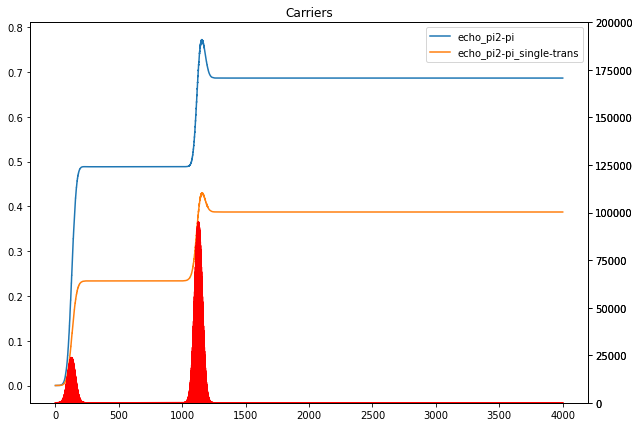

In [75]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    ax2 = ax.twinx()
    field = val['results']['external_field']
    inte = field['Intensity']
    ax2.plot(time,inte,label=study,c='red')
    ax2.set_ylim(0,2e5)
    ax.set_title('Carriers')
    ax.legend(loc='best')

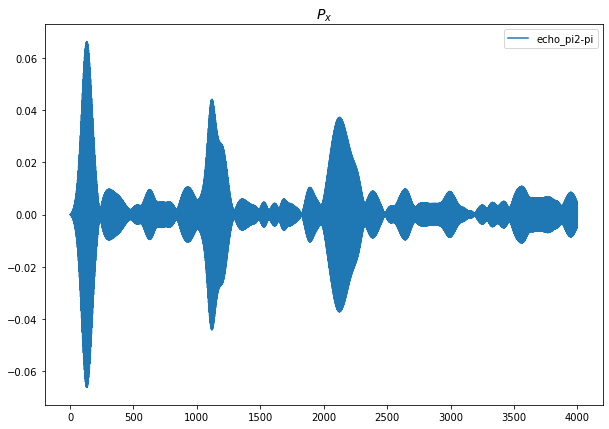

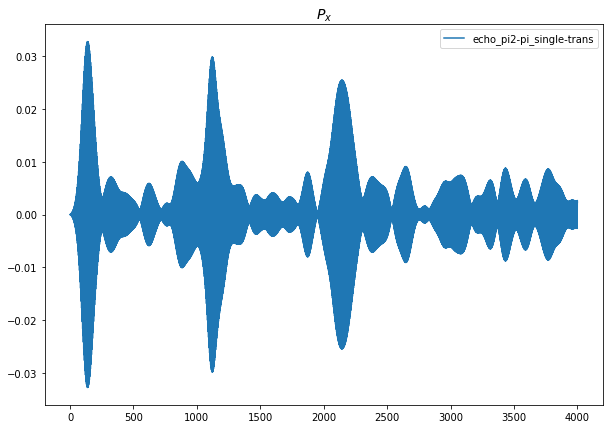

In [76]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()